In [1]:
!pip install pytorch-ignite -q

In [2]:
import torch
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [3]:
#Data was already preprocessed so we grab it locally
train_df = pd.read_csv("train.csv")
validation_df = pd.read_csv("validation.csv")
print(train_df.shape)
print(validation_df.shape)
print(train_df.shape)

(2332, 67)
(665, 67)
(2332, 67)


In [4]:
# Grabbing our features and labels for training and validation
num_features = train_df.shape[1]-1
num_neurons = 1000
dropout_value = 0.5
y_train = train_df.iloc[:,0]
x_train = train_df.iloc[:, 1:]

y_validation = validation_df.iloc[:,0]
x_validation = validation_df.iloc[:,1:]



In [5]:
class FeedForwardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(num_features, num_neurons),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, num_neurons),
            nn.Dropout(p=dropout_value),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, num_neurons),
            nn.Dropout(p=dropout_value),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, num_neurons),
            nn.Dropout(p=dropout_value),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, num_neurons),
            nn.Dropout(p=dropout_value),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, num_neurons),
            nn.Dropout(p=dropout_value),
            nn.LeakyReLU(),
            nn.Linear(num_neurons, 1),
            nn.Sigmoid()
        )
    def forward(self, x: torch.tensor):
        return self.network(x)

In [6]:
import ignite.contrib.metrics as icm

def train(x, y, model, opt, loss_fn, epochs=10000):
    train_loss_values = []
    train_auc_values = []
    metric = icm.ROC_AUC()

    for epoch in tqdm(range(epochs)):
        model.train()
        pred = model(x)
        loss = loss_fn(pred, torch.unsqueeze(y, 1))
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_values.append(loss.item())
        
        if epoch % 100 == 0:
            metric.update(((pred), y))
            train_auc = metric.compute()
            train_auc_values.append(train_auc)

    return train_loss_values, train_auc_values

def validate(x,y, model, loss_fn):
    with torch.inference_mode():
        metric = icm.ROC_AUC()
        model.eval()
        pred = model(x)
        loss = loss_fn(pred, torch.unsqueeze(y, 1))
        metric.update(((pred), y))
        auc = metric.compute()
        print(f"Evaluation Loss is {loss.item()} and AUC is {auc}")

In [7]:
device = torch.device("cuda")
#Mapping our features and labels as tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)

x_validation_tensor = torch.tensor(x_validation.values, dtype=torch.float)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float)

x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

x_validation_tensor = x_validation_tensor.to(device)
y_validation_tensor = y_validation_tensor.to(device)
model = FeedForwardModel()
model.to(device)
loss_fn = nn.BCELoss()
opt = optim.Adam(params=model.parameters(), lr=0.00001)

In [8]:
import matplotlib.pyplot as plt

def plot_loss(loss_list):
    x = torch.arange(len(loss_list))
    plt.figure(figsize=(10,7))
    plt.plot(x, loss_list)
    

In [9]:
losses, aucs=train(x_train_tensor, y_train_tensor, model, opt, loss_fn)

100%|██████████| 10000/10000 [02:54<00:00, 57.38it/s]


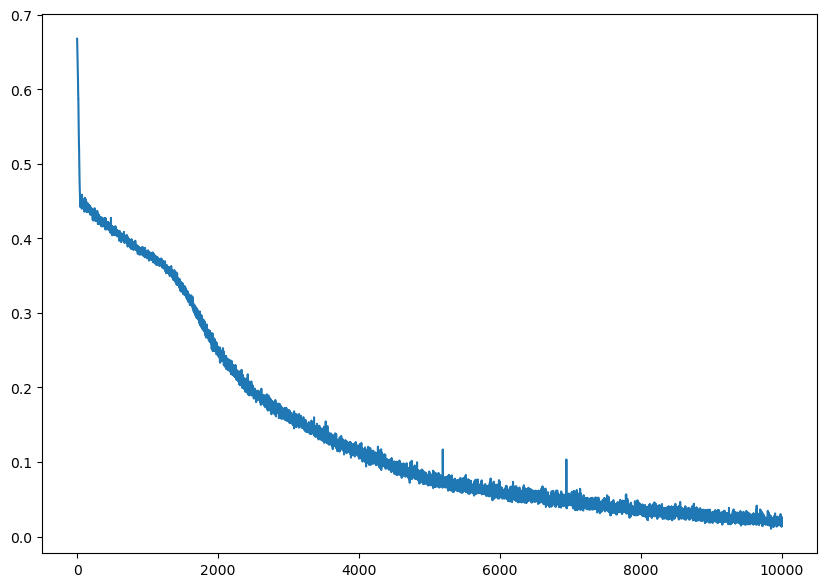

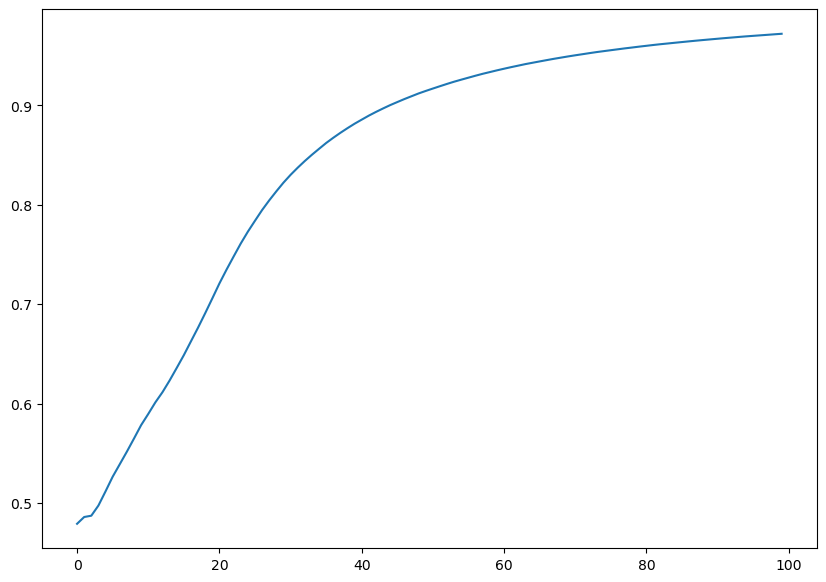

In [10]:
plot_loss(losses)
plot_loss(aucs)

In [14]:
validate(x_validation_tensor, y_validation_tensor, model, loss_fn)
validate(x_train_tensor, y_train_tensor, model, loss_fn)

Evaluation Loss is 3.0315353870391846 and AUC is 0.7495942028985507
Evaluation Loss is 0.005076625384390354 and AUC is 0.9999766598834452


In [31]:
#Running a single training job with Sagemaker
from sagemaker.pytorch import PyTorch
import sagemaker
from sagemaker import get_execution_role
import boto3

role = get_execution_role()
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = 'churn'
#Uploading the files into S3
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(
    prefix, 'validation/validation.csv')).upload_file('validation.csv')

s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters={"epochs": 1000, "neurons": 100},
)

estimator.fit({"train":s3_input_train, "validate": s3_input_validation})

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-23-15-54-12-082


2023-02-23 15:54:12 Starting - Starting the training job...
2023-02-23 15:54:30 Starting - Preparing the instances for training......
2023-02-23 15:55:21 Downloading - Downloading input data...
2023-02-23 15:56:11 Training - Downloading the training image...
2023-02-23 15:56:32 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-23 10:56:40,459 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-23 10:56:40,460 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-23 10:56:40,462 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-02-23 10:56:40,473 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-23 10:56:40,475 sagemaker_pytorch_container.training INFO     Invoking user training 

In [ ]:
#HPT
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=1,
    instance_type="ml.c5.2xlarge",
)
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

hyper_ranges = {
    "lr": ContinuousParameter(1e-4, 1e-2),
    "neurons": IntegerParameter(20, 2048),
    "dropout": ContinuousParameter(0,1),
    "epochs": IntegerParameter(100, 50000)
}

objective_name = "Validation_roc_auc"
metric_definitions = [{"Name": objective_name, "Regex": "AUC: ([0-9\\.]+)"}]

from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner(
    estimator,
    objective_name,
    hyper_ranges,
    metric_definitions,
    max_jobs=50,
    max_parallel_jobs=5,
)

tuner.fit({"train":s3_input_train, "validate": s3_input_validation})


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230223-1604


.....................................................................................................................................................................................................................